In [1]:
import sys
sys.path.append("code")

# %load_ext autoreload

In [2]:
import spiceypy as spice
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib import dates
from datetime import datetime

In [3]:
from spice_tools import calculate_eclipses, as_et, as_utc, as_tdb
from simulation_tools import load_simulation_results
from plotting import format_plot, save_plot

In [4]:
def print_eclipses(occulted, occulting, observer, start, stop):
    occultations = calculate_eclipses(occulted, occulting, observer, start, stop)
    
    print(f"{observer} observing {occulted} occultation due to {occulting}:")
    if not occultations:
        print(" - No occultations")
    for t_start, t_end, occ_type in occultations:
        duration = (t_end - t_start) / 60  # min
        duration_h = duration // 60
        duration_min = duration - duration_h * 60
        print(f" - {as_utc(t_start)} - {as_utc(t_end)} ({occ_type} for {duration_h:.0f}:{duration_min:.0f})")

## Check eclipses given in Tooley 2010:

In [5]:
print_eclipses("Sun", "Earth", "LRO", "2009 DEC 30", "2010 JAN 1")
print_eclipses("Sun", "Moon", "LRO", "2009 DEC 30", "2010 JAN 1")

LRO observing Sun occultation due to Earth:
 - 2009-12-31 17:46:07 UTC - 2009-12-31 20:51:28 UTC (PARTIAL for 3:5)
LRO observing Sun occultation due to Moon:
 - No occultations


In [6]:
print_eclipses("Sun", "Earth", "Moon", "2010 JUNE 26", "2010 JUNE 27")
print_eclipses("Sun", "Earth", "LRO", "2010 JUNE 25", "2010 JUNE 27")
print_eclipses("Sun", "Moon", "LRO", "2010 JUNE 25", "2010 JUNE 27")

Moon observing Sun occultation due to Earth:
 - 2010-06-26 09:35:43 UTC - 2010-06-26 11:26:58 UTC (PARTIAL for 1:51)
 - 2010-06-26 11:26:58 UTC - 2010-06-26 11:51:21 UTC (FULL for 0:24)
 - 2010-06-26 11:51:21 UTC - 2010-06-26 13:42:38 UTC (PARTIAL for 1:51)
LRO observing Sun occultation due to Earth:
 - 2010-06-26 09:52:32 UTC - 2010-06-26 10:22:53 UTC (PARTIAL for 0:30)
 - 2010-06-26 10:22:53 UTC - 2010-06-26 10:51:52 UTC (FULL for 0:29)
 - 2010-06-26 10:51:52 UTC - 2010-06-26 12:26:56 UTC (PARTIAL for 1:35)
 - 2010-06-26 12:26:56 UTC - 2010-06-26 12:55:56 UTC (FULL for 0:29)
 - 2010-06-26 12:55:56 UTC - 2010-06-26 13:26:33 UTC (PARTIAL for 0:31)
LRO observing Sun occultation due to Moon:
 - No occultations


In [7]:
print_eclipses("Sun", "Earth", "LRO", "2010 DEC 20", "2010 DEC 22")
print_eclipses("Sun", "Moon", "LRO", "2010 DEC 20", "2010 DEC 22")

LRO observing Sun occultation due to Earth:
 - 2010-12-21 05:45:56 UTC - 2010-12-21 07:27:13 UTC (PARTIAL for 1:41)
 - 2010-12-21 07:27:13 UTC - 2010-12-21 09:11:34 UTC (FULL for 1:44)
 - 2010-12-21 09:11:34 UTC - 2010-12-21 10:52:26 UTC (PARTIAL for 1:41)
LRO observing Sun occultation due to Moon:
 - No occultations


In [8]:
print_eclipses("Sun", "Earth", "LRO", "2011 JUN 14", "2011 JUN 16")
print_eclipses("Sun", "Moon", "LRO", "2011 JUN 14", "2011 JUN 16")

LRO observing Sun occultation due to Earth:
 - 2011-06-15 17:35:04 UTC - 2011-06-15 19:07:13 UTC (PARTIAL for 1:32)
 - 2011-06-15 19:07:13 UTC - 2011-06-15 21:16:23 UTC (FULL for 2:9)
 - 2011-06-15 21:16:23 UTC - 2011-06-15 22:48:33 UTC (PARTIAL for 1:32)
LRO observing Sun occultation due to Moon:
 - No occultations


## Verify simulation of 26 June 2010 eclipse

In [9]:
print_eclipses("Sun", "Earth", "Moon", "2010 JUNE 26", "2010 JUNE 27")
print_eclipses("Sun", "Earth", "LRO", "2010 JUNE 25", "2010 JUNE 27")
print_eclipses("Sun", "Moon", "LRO", "2010 JUNE 25", "2010 JUNE 27")

Moon observing Sun occultation due to Earth:
 - 2010-06-26 09:35:43 UTC - 2010-06-26 11:26:58 UTC (PARTIAL for 1:51)
 - 2010-06-26 11:26:58 UTC - 2010-06-26 11:51:21 UTC (FULL for 0:24)
 - 2010-06-26 11:51:21 UTC - 2010-06-26 13:42:38 UTC (PARTIAL for 1:51)
LRO observing Sun occultation due to Earth:
 - 2010-06-26 09:52:32 UTC - 2010-06-26 10:22:53 UTC (PARTIAL for 0:30)
 - 2010-06-26 10:22:53 UTC - 2010-06-26 10:51:52 UTC (FULL for 0:29)
 - 2010-06-26 10:51:52 UTC - 2010-06-26 12:26:56 UTC (PARTIAL for 1:35)
 - 2010-06-26 12:26:56 UTC - 2010-06-26 12:55:56 UTC (FULL for 0:29)
 - 2010-06-26 12:55:56 UTC - 2010-06-26 13:26:33 UTC (PARTIAL for 0:31)
LRO observing Sun occultation due to Moon:
 - No occultations


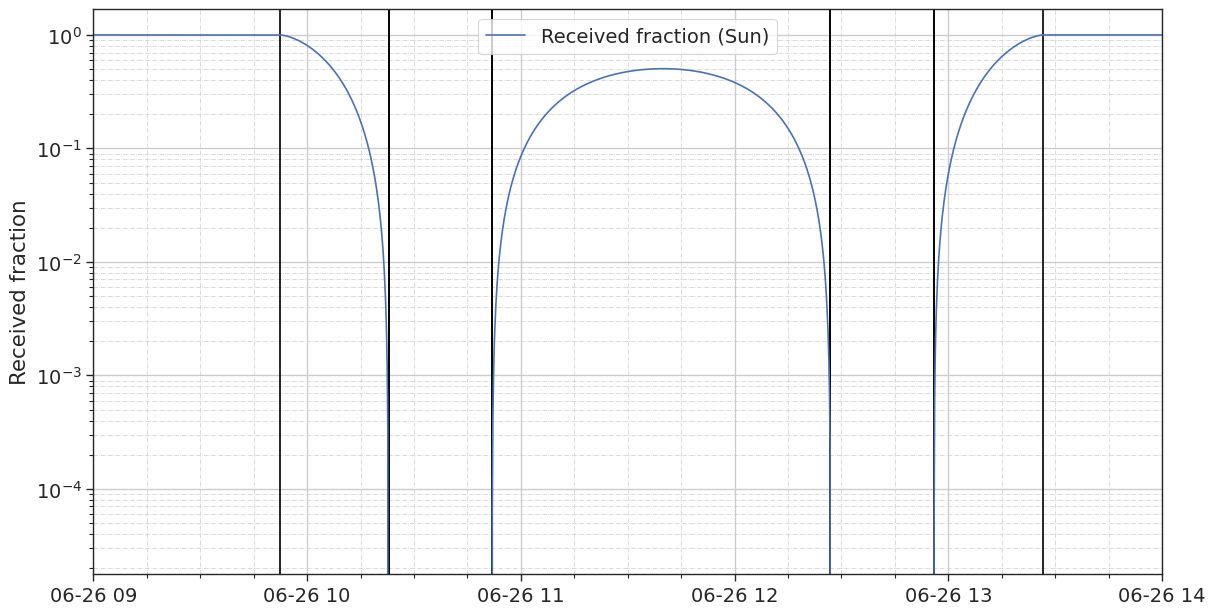

In [10]:
def plot_sun_occultation():
    df = load_simulation_results("../results/2023-01-27T10-00-57-77048/95")

    plt.figure(figsize=[12, 6])

    occultations = calculate_eclipses("Sun", "Earth", "LRO", "2010 JUNE 25", "2010 JUNE 27")
    for t_start, t_end, occ_type in occultations:
        plt.axvline(dates.datestr2num(as_utc(t_start)), 0, 1, c="black")
        plt.axvline(dates.datestr2num(as_utc(t_end)), 0, 1, c="black")

    plt.plot(df.index, df["occ_sun"], label="Received fraction (Sun)")

    plt.legend()
    plt.ylabel("Received fraction")
    plt.yscale("log")

    plt.xlim([datetime(2010, 6, 26, 9), datetime(2010, 6, 26, 14)])

    format_plot()

plot_sun_occultation()

Occultation of sun as calculated by Tudat agrees with SPICE occultations

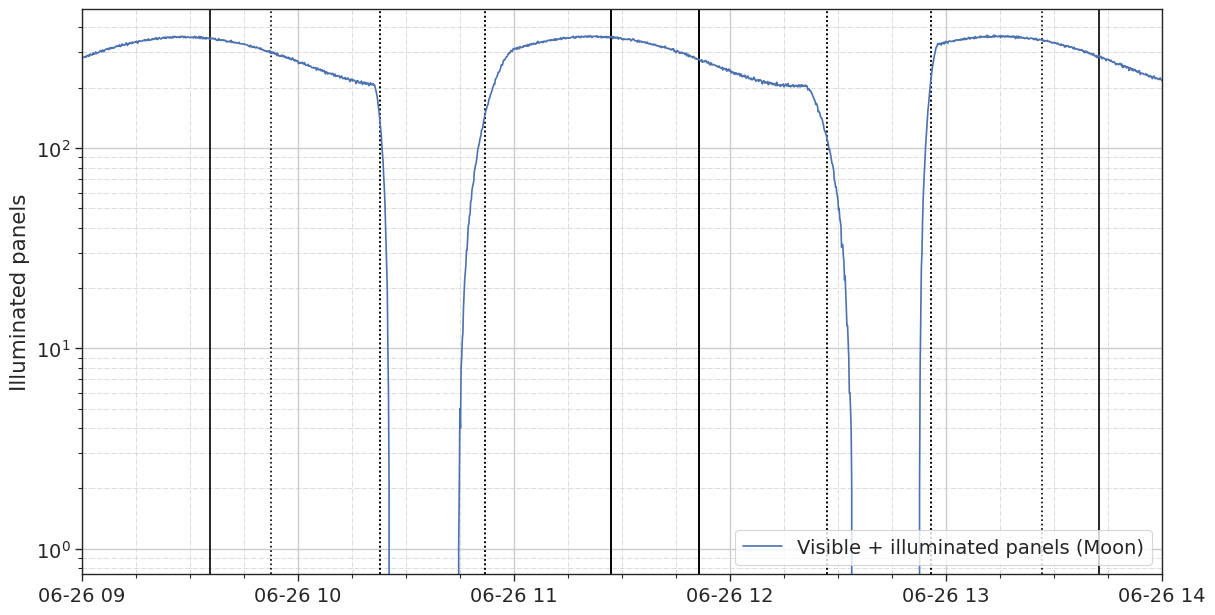

In [22]:
def plot_moon_occultation():
    df = load_simulation_results("../results/2023-01-27T10-00-57-77048/95")

    plt.figure(figsize=[12, 6])

    occultations = calculate_eclipses("Sun", "Earth", "Moon", "2010 JUNE 25", "2010 JUNE 27")
    for t_start, t_end, occ_type in occultations:
        plt.axvline(dates.datestr2num(as_utc(t_start)), 0, 1, c="black")
        plt.axvline(dates.datestr2num(as_utc(t_end)), 0, 1, c="black")
    
    occultations = calculate_eclipses("Sun", "Earth", "LRO", "2010 JUNE 25", "2010 JUNE 27")
    for t_start, t_end, occ_type in occultations:
        plt.axvline(dates.datestr2num(as_utc(t_start)), 0, 1, c="black", ls=":")
        plt.axvline(dates.datestr2num(as_utc(t_end)), 0, 1, c="black", ls=":")

    plt.plot(df.index, df["panels_vis_ill_moon"], label="Visible + illuminated panels (Moon)")

    plt.legend()
    plt.ylabel("Illuminated panels")
    plt.yscale("log")

    plt.xlim([datetime(2010, 6, 26, 9), datetime(2010, 6, 26, 14)])

    format_plot()

plot_moon_occultation()

Moon albedo + thermal radiation is harder to check with SPICE occultations, but likely agrees

## Point-to-point occultation

In [12]:
def check_visibility(source_position, occulting_body_position, occulting_body_radius, target_position):
    body_to_target = occulting_body_position - target_position
    source_to_target = source_position - target_position
    alpha = np.arccos(np.dot(body_to_target, source_to_target) / (norm(body_to_target) * norm(source_to_target)))
    apparent_separation = norm(body_to_target) * np.sin(alpha)
    
    target_to_body = target_position - occulting_body_position
    source_to_body = source_position - occulting_body_position
    cos_psi = np.dot(target_to_body, source_to_body) / (norm(target_to_body) * norm(source_to_body))
    
    outside_body_radius = apparent_separation > occulting_body_radius
    target_in_front_of_occulting_body_center = cos_psi > 0
    
    return target_in_front_of_occulting_body_center or outside_body_radius

In [13]:
check_visibility(
    np.array([0.5, 0, 0]),
    np.array([2, 0, 0]),
    1,
    np.array([0, 0, 0])
)

True

In [14]:
check_visibility(
    np.array([0, 0, 0]),
    np.array([2, 0, 0]),
    1,
    np.array([0.5, 0, 0])
)

True

In [15]:
check_visibility(
    np.array([0, 0, 0]),
    np.array([2, 0, 0]),
    1,
    np.array([3, 1, 0])
)

False

In [16]:
check_visibility(
    np.array([0, 0, 0]),
    np.array([2, 0, 0]),
    1,
    np.array([3, 2, 0])
)

True

In [17]:
check_visibility(
    np.array([0, 0, 0]),
    np.array([2, 0, 0]),
    1,
    np.array([1.5, 0, 0])
)

True

In [18]:
check_visibility(
    np.array([0, 0, 0]),
    np.array([2, 0, 0]),
    1,
    np.array([2.5, 0, 0])
)

False